REVIEWING AND MERGING DATASETS

In [2]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = r"C:\\Users\\user3\\Downloads\\RTU-HVAC Sensor Data -No time.xlsx"
xls = pd.ExcelFile(file_path)

PP1 = pd.read_excel(xls, sheet_name="RTU-HVAC Sensor Data_Dataset1")
PP2 = pd.read_excel(xls, sheet_name="RTU-HVAC Sensor Data_Dataset2")

PP1.info()  # Check data types and missing values
PP2.info()  # Check data types and missing values

print("\nMissing Values:\n", PP1.isnull().sum())  # Missing value count
print("\nDuplicate Entries:", PP1.duplicated().sum())  # Check for duplicates
print("\nBasic Statistics:\n", PP1.describe())  # Summary statistics

print("\nMissing Values:\n", PP2.isnull().sum())  # Missing value count
print("\nDuplicate Entries:", PP2.duplicated().sum())  # Check for duplicates
print("\nBasic Statistics:\n", PP2.describe())  # Summary statistics


# Merge datasets by aligning feature names
PP2.rename(columns={"COMP.A": "COMP"}, inplace=True)
PP_combined = pd.concat([PP1, PP2], ignore_index=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4284 entries, 0 to 4283
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Count           4284 non-null   int64  
 1   RUAVG           4284 non-null   float64
 2   FAN             4284 non-null   float64
 3   COMP            4284 non-null   float64
 4   MAIN            4284 non-null   float64
 5   FLW             4284 non-null   float64
 6   ECRH            4284 non-null   float64
 7   ORH             4284 non-null   float64
 8   RERH            4284 non-null   float64
 9   SURH            4284 non-null   float64
 10  SUAVG           4284 non-null   float64
 11  ECT             4284 non-null   float64
 12  OT              4284 non-null   float64
 13  IT              4284 non-null   float64
 14  RET             4284 non-null   float64
 15  SUT             4284 non-null   float64
 16  DISP2           4284 non-null   float64
 17  DISP1           4284 non-null   f

INTRODUCING ROLLING AVERAGES AND RATE OF CHANGES

In [3]:
from sklearn.preprocessing import MinMaxScaler


# Create Rolling Averages & Rate of Change Features
rolling_window = 5  

for col in PP_combined.select_dtypes(include=[np.number]).columns:
    PP_combined[f"{col}_rolling_avg"] = PP_combined[col].rolling(window=rolling_window).mean()
    PP_combined[f"{col}_rate_of_change"] = PP_combined[col].diff()

# Drop initial NaN values caused by rolling mean
PP_combined.dropna(inplace=True)

# Select only rolling average and rate-of-change features
feature_columns = [col for col in PP_combined.columns if '_rolling_avg' in col or '_rate_of_change' in col]
PP_selected = PP_combined[feature_columns]

# Apply Min-Max Scaling (values between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
PP_scaled = pd.DataFrame(scaler.fit_transform(PP_selected), columns=PP_selected.columns)

# Print updated data summary
print("\nMerged Dataset Summary:\n")
PP_scaled.info()
print("\nMerged Dataset Statistics:\n", PP_scaled.describe())



Merged Dataset Summary:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7153 entries, 0 to 7152
Data columns (total 62 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Count_rolling_avg              7153 non-null   float64
 1   Count_rate_of_change           7153 non-null   float64
 2   RUAVG_rolling_avg              7153 non-null   float64
 3   RUAVG_rate_of_change           7153 non-null   float64
 4   FAN_rolling_avg                7153 non-null   float64
 5   FAN_rate_of_change             7153 non-null   float64
 6   COMP_rolling_avg               7153 non-null   float64
 7   COMP_rate_of_change            7153 non-null   float64
 8   MAIN_rolling_avg               7153 non-null   float64
 9   MAIN_rate_of_change            7153 non-null   float64
 10  FLW_rolling_avg                7153 non-null   float64
 11  FLW_rate_of_change             7153 non-null   float64
 12  ECRH_rolling_avg      

CATEGORIZING FAULTS


🔍 **Faults Detected Summary:**
⚠️ ALERT: 1578 instances of 'Low Airflow' detected!
⚠️ ALERT: 977 instances of 'Inefficiency Fault' detected!
⚠️ ALERT: 801 instances of 'Evaporator Coil Freezing' detected!
⚠️ ALERT: 396 instances of 'Overheating Fault' detected!
⚠️ ALERT: 39 instances of 'Circuit 2 Compressor Overload' detected!


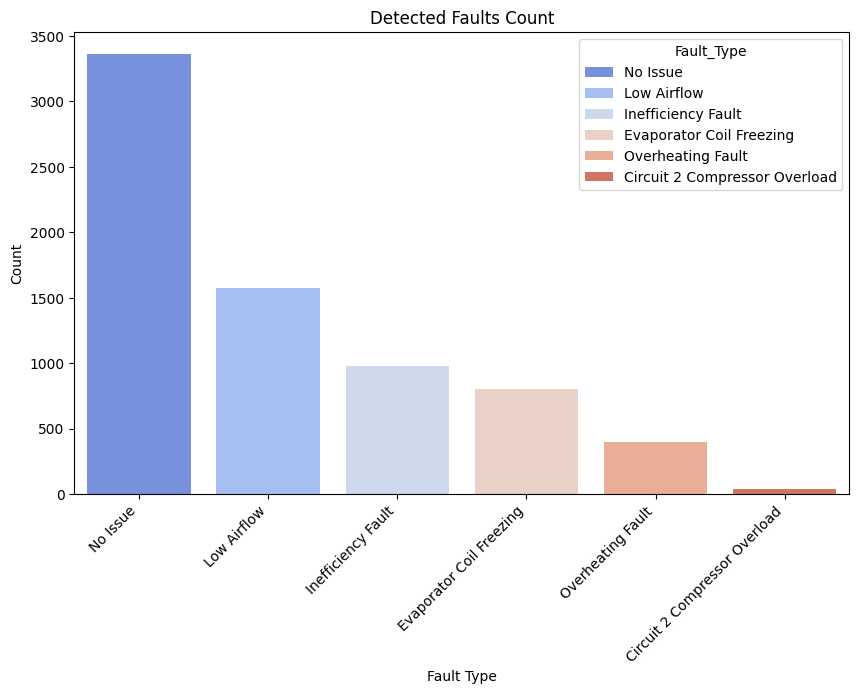

In [4]:
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns

# Define Z-Score threshold for anomaly detection
z_threshold = 0.9 

# Define Fault Conditions Based on Processed Features
PP_scaled["Fault_Type"] = np.select(
    [
        # Compressor Overload: High Compressor Load & Increasing Trend (Circuit 1 & Circuit 2)
        # A continuously overloaded compressor may indicate excessive cooling demand, potential motor damage, or system inefficiency.
        ((zscore(PP_scaled["COMP_rolling_avg"]) > z_threshold) & 
         (zscore(PP_scaled["COMP_rate_of_change"]) > z_threshold) & 
         (PP_scaled["COMP_rolling_avg"] > PP_scaled["COMP_rolling_avg"].quantile(0.80))),
        
        ((zscore(PP_scaled["COMP.B_rolling_avg"]) > z_threshold) & 
         (zscore(PP_scaled["COMP.B_rate_of_change"]) > z_threshold) & 
         (PP_scaled["COMP.B_rolling_avg"] > PP_scaled["COMP.B_rolling_avg"].quantile(0.80))),
        
        # Low Airflow: If Airflow Drops Significantly or is Decreasing Rapidly
        # Low airflow can indicate a clogged filter, fan failure, or duct blockage.
        ((zscore(PP_scaled["FLW_rolling_avg"]) < -z_threshold) | 
         (zscore(PP_scaled["FLW_rate_of_change"]) < -z_threshold)),
        
        # High Power Consumption: Main Power Consumption is Abnormally High
        # Could indicate inefficiency, electrical issues, or overworked components.
        ((PP_scaled["MAIN_rolling_avg"] > PP_scaled["MAIN_rolling_avg"].quantile(0.90)) & 
         (PP_scaled["MAIN_rate_of_change"] > PP_scaled["MAIN_rate_of_change"].quantile(0.90))),
        
        # Evaporator Coil Freezing: Extremely Low Evaporator Temperature
        # A frozen evaporator coil leads to reduced efficiency and can damage the system. Often caused by low refrigerant levels or low airflow.
        (zscore(PP_scaled["EVAT_rolling_avg"]) < -z_threshold),
        
        # Overcooling: External and Evaporator Temperature Drops Too Much
        # Excessive cooling wastes energy and may indicate faulty thermostats or sensors.
        ((zscore(PP_scaled["EXT2_rolling_avg"]) < -z_threshold) & 
         (zscore(PP_scaled["EVAT_rolling_avg"]) < -z_threshold)) & 
        (PP_scaled["EXT2_rolling_avg"] < PP_scaled["EXT2_rolling_avg"].quantile(0.10)),
        
        # System Blockage Fault: Low Airflow & High Compressor Load (Circuit 1 & Circuit 2)
        # A blocked duct or clogged filter causes low airflow. The compressor compensates by overworking, increasing energy usage.
        ((zscore(PP_scaled["FLW_rolling_avg"]) < -z_threshold) & 
         ((zscore(PP_scaled["COMP_rolling_avg"]) > z_threshold) |
          (zscore(PP_scaled["COMP.B_rolling_avg"]) > z_threshold))),
        
        # Overheating Fault: If Both Power Consumption and Outdoor Temperature are High
        # May indicate insufficient cooling capacity, leading to overheating.
        ((zscore(PP_scaled["MAIN_rolling_avg"]) > z_threshold) & 
         (zscore(PP_scaled["OT_rolling_avg"]) > z_threshold)),
        
        # Inefficiency Fault: If Either Circuit is Working Too Hard Despite Normal Airflow
        # Suggests the system is using too much energy despite sufficient airflow, meaning it is inefficient.
        (((zscore(PP_scaled["COMP_rolling_avg"]) > z_threshold) | 
          (zscore(PP_scaled["COMP.B_rolling_avg"]) > z_threshold)) & 
         (PP_scaled["FLW_rolling_avg"] > PP_scaled["FLW_rolling_avg"].quantile(0.40)) & 
         (PP_scaled["MAIN_rolling_avg"] > PP_scaled["MAIN_rolling_avg"].quantile(0.40)))
    ],
    ["Circuit 1 Compressor Overload", "Circuit 2 Compressor Overload", "Low Airflow", "High Power Consumption", "Evaporator Coil Freezing", 
     "Overcooling", "System Blockage Fault", "Overheating Fault", "Inefficiency Fault"],
    default="No Issue"
)

# Print Fault Summary
fault_counts = PP_scaled["Fault_Type"].value_counts()
print("\n🔍 **Faults Detected Summary:**")
for fault, count in fault_counts.items():
    if fault != "No Issue":
        print(f"⚠️ ALERT: {count} instances of '{fault}' detected!")

# Visualize Fault Distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=fault_counts.index, y=fault_counts.values, hue=fault_counts.index, palette="coolwarm", legend=True)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Fault Type")
plt.ylabel("Count")
plt.title("Detected Faults Count")
plt.show()


DATA CLASSIFICATION - Test & Train

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib

# Encode Fault Types to Numeric Labels
label_encoder = LabelEncoder()
PP_scaled["Fault_Type_Num"] = label_encoder.fit_transform(PP_scaled["Fault_Type"])

# Save the label encoder
joblib.dump(label_encoder, "label_encoder.pkl")
print("✅ Label Encoder Saved as 'label_encoder.pkl'")

# Display the mapping of fault labels
fault_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nFault Type Mapping:", fault_mapping)

# Define Features and Target
X = PP_scaled.drop(columns=["Fault_Type", "Fault_Type_Num"], errors='ignore')
y = PP_scaled["Fault_Type_Num"]  # Target variable

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Before applying SMOTE
print("Before SMOTE:", Counter(y_train))

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# After applying SMOTE
print("After SMOTE:", Counter(y_train_resampled))

✅ Label Encoder Saved as 'label_encoder.pkl'

Fault Type Mapping: {'Circuit 2 Compressor Overload': np.int64(0), 'Evaporator Coil Freezing': np.int64(1), 'Inefficiency Fault': np.int64(2), 'Low Airflow': np.int64(3), 'No Issue': np.int64(4), 'Overheating Fault': np.int64(5)}
Before SMOTE: Counter({4: 2689, 3: 1262, 2: 782, 1: 641, 5: 317, 0: 31})
After SMOTE: Counter({3: 2689, 4: 2689, 1: 2689, 2: 2689, 5: 2689, 0: 2689})


KNN Model 

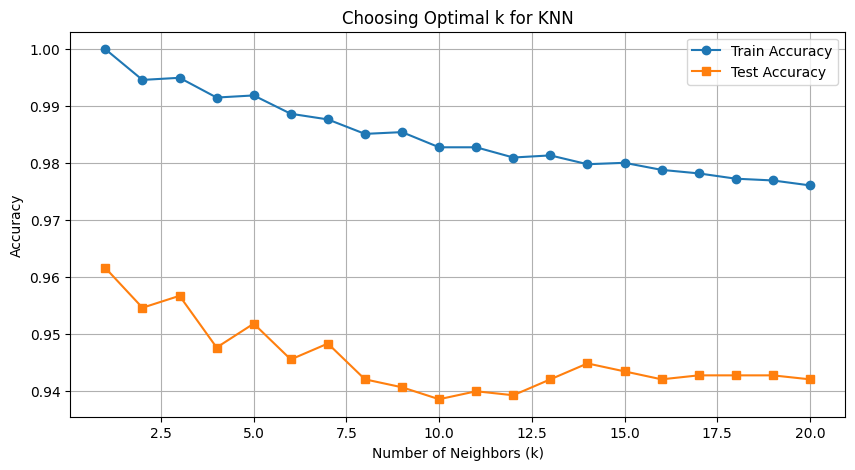

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Try different values of n_neighbors
neighbor_values = range(1, 21)  # Test k from 1 to 20
train_accuracies = []
test_accuracies = []

for k in neighbor_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_resampled, y_train_resampled)  # Train on SMOTE-balanced data
    
    # Check accuracy on training data
    y_train_pred = knn.predict(X_train_resampled)
    train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
    train_accuracies.append(train_accuracy)
    
    # Check accuracy on test data
    y_test_pred = knn.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

# Plot Accuracy vs. n_neighbors
plt.figure(figsize=(10, 5))
plt.plot(neighbor_values, train_accuracies, label="Train Accuracy", marker='o')
plt.plot(neighbor_values, test_accuracies, label="Test Accuracy", marker='s')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("Choosing Optimal k for KNN")
plt.legend()
plt.grid(True)
plt.show()

KNN Accuracy: 0.9580712788259959
              precision    recall  f1-score   support

           0       0.25      0.12      0.17         8
           1       0.91      0.97      0.94       160
           2       0.93      0.94      0.94       195
           3       0.99      1.00      1.00       316
           4       0.98      0.95      0.96       673
           5       0.87      0.95      0.91        79

    accuracy                           0.96      1431
   macro avg       0.82      0.82      0.82      1431
weighted avg       0.96      0.96      0.96      1431



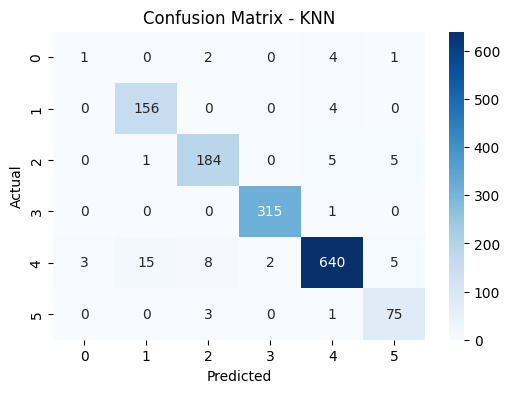

['hvac_knn_model.pkl']

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib


# Train K-Nearest Neighbors (KNN) model
knn_model = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the KNN model
y_pred_knn = knn_model.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn, zero_division=1))

# Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - KNN')
plt.show()

# Save the KNN model
joblib.dump(knn_model, 'hvac_knn_model.pkl')

RANDOM FOREST MODEL

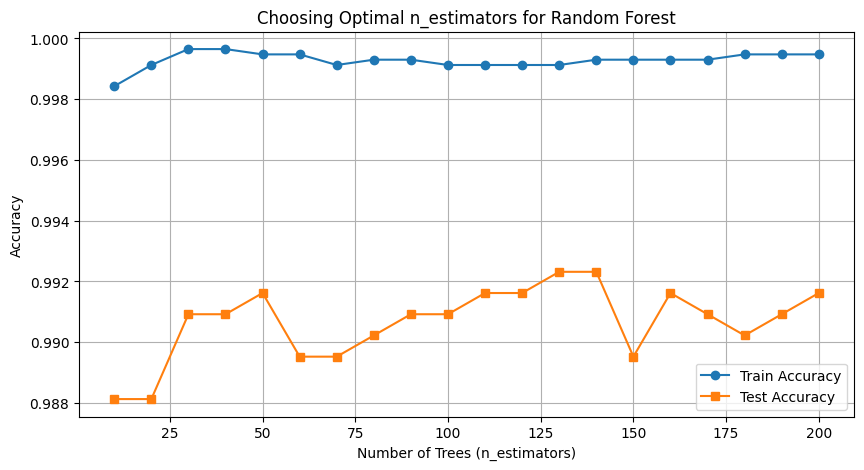

In [10]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Define different values of n_estimators to test
n_estimators_values = range(10, 210, 10)  # Testing from 10 to 200 in steps of 10

# Store accuracy scores
train_accuracies = []
test_accuracies = []

# Loop through different n_estimators values
for n in n_estimators_values:
    rf_temp = RandomForestClassifier(
        n_estimators=n,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight="balanced",
        random_state=42
    )
    rf_temp.fit(X_train, y_train)

    # Train accuracy
    y_train_pred = rf_temp.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)

    # Test accuracy
    y_test_pred = rf_temp.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

# Plot accuracy vs. n_estimators
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(n_estimators_values, train_accuracies, label="Train Accuracy", marker='o')
plt.plot(n_estimators_values, test_accuracies, label="Test Accuracy", marker='s')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Choosing Optimal n_estimators for Random Forest")
plt.legend()
plt.grid(True)
plt.show()



Random Forest Accuracy: 0.9909154437456325

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       1.00      1.00      1.00       160
           2       0.98      0.98      0.98       195
           3       1.00      1.00      1.00       316
           4       0.99      1.00      1.00       673
           5       0.95      0.97      0.96        79

    accuracy                           0.99      1431
   macro avg       0.99      0.89      0.91      1431
weighted avg       0.99      0.99      0.99      1431



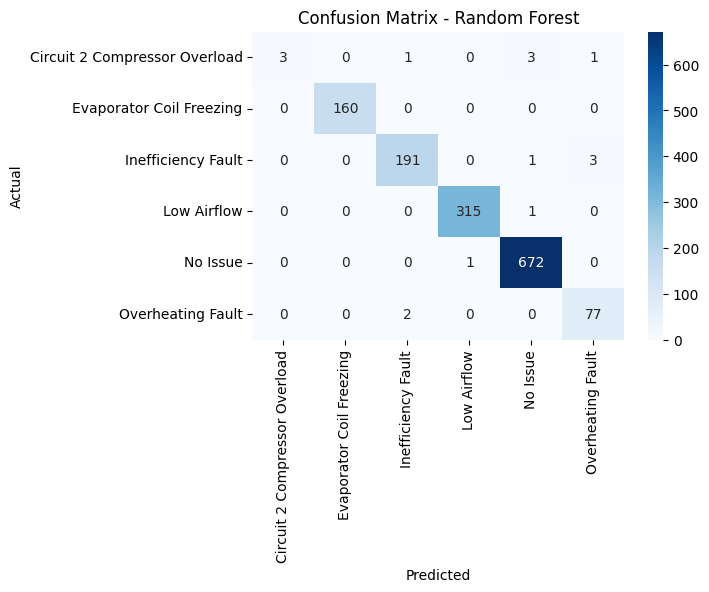

C:\Users\user3\AppData\Local\Temp\ipykernel_25816\2838532165.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df[:15], palette="coolwarm")


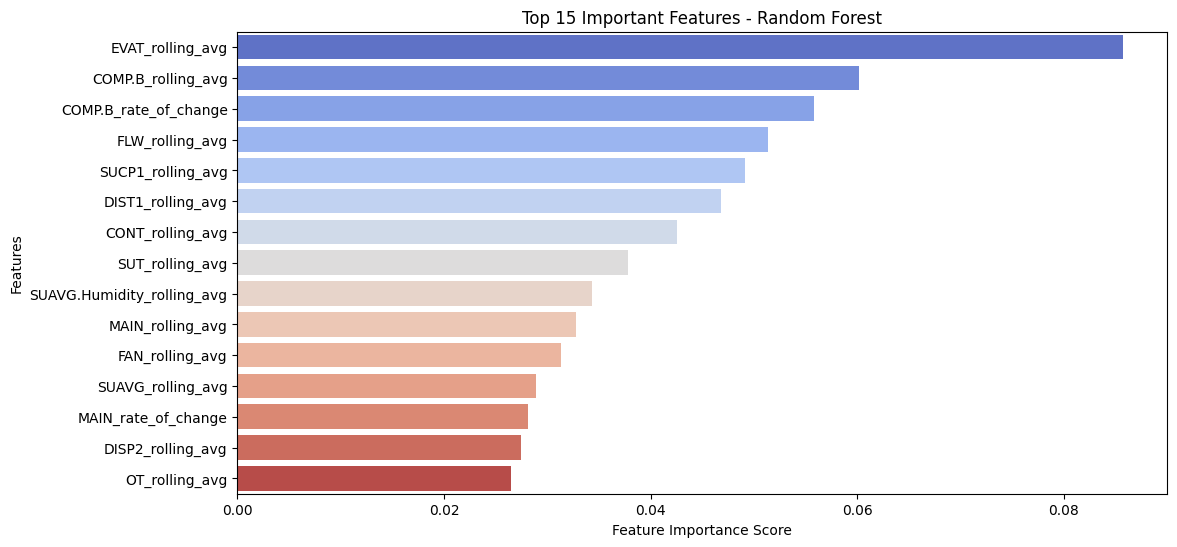


✅ Random Forest model saved as 'hvac_rf_model.pkl'


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=10,  # Limits tree depth to prevent overfitting
    min_samples_split=5,  # Min samples to split a node
    min_samples_leaf=2,  # Min samples per leaf node
    class_weight="balanced",  # Handles class imbalance
    random_state=42
)

rf_model.fit(X_train, y_train)

# ======= Step 3: Evaluate Model =======
y_pred_rf = rf_model.predict(X_test)

print("\nRandom Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, zero_division=1))

# ======= Step 4: Confusion Matrix Visualization =======
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap="Blues",
            xticklabels=fault_mapping.keys(), yticklabels=fault_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# ======= Step 5: Feature Importance Analysis =======
feature_importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df[:15], palette="coolwarm")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top 15 Important Features - Random Forest")
plt.show()

# ======= Step 6: Save the Model =======
joblib.dump(rf_model, 'hvac_rf_model.pkl')
print("\n✅ Random Forest model saved as 'hvac_rf_model.pkl'")

KNN MODEL VS RANDOM FOREST MODEL COMPARISION


Model Comparison Results:
           Model  Accuracy  Precision (Weighted Avg)  Recall (Weighted Avg)  \
0  Random Forest  0.990915                  0.990994               0.990915   
1            KNN  0.958071                  0.957189               0.958071   

   F1-Score (Weighted Avg)  
0                 0.990147  
1                 0.957199  


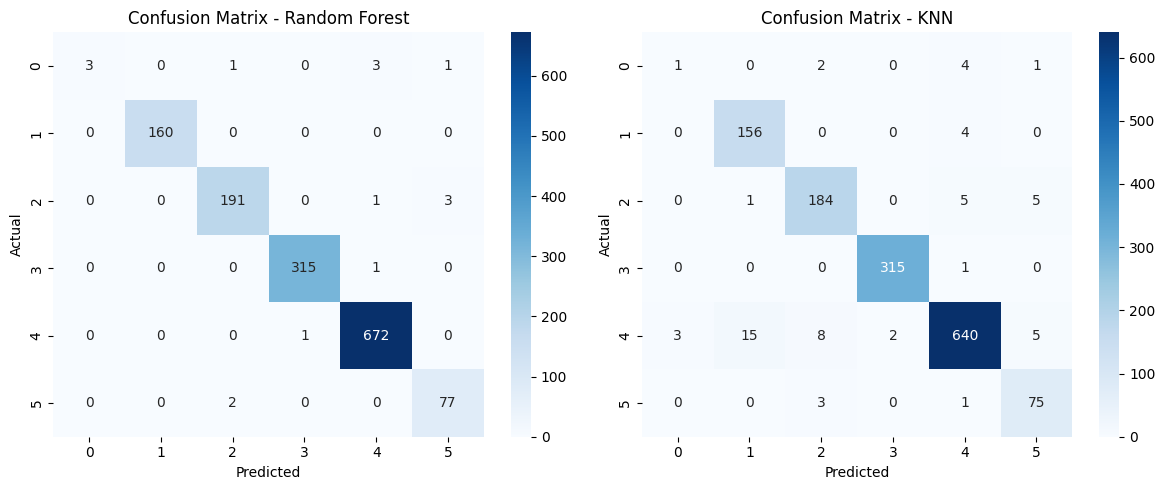

In [8]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load models
rf_model = joblib.load("hvac_rf_model.pkl")
knn_model = joblib.load("hvac_knn_model.pkl")

# Store models
models = {
    "Random Forest": rf_model,
    "KNN": knn_model,
}

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test)

# Accuracy Scores
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

# Classification Reports
report_rf = classification_report(y_test, y_pred_rf, zero_division=1, output_dict=True)
report_knn = classification_report(y_test, y_pred_knn, zero_division=1, output_dict=True)

# Store results in DataFrame
model_results = pd.DataFrame({
    "Model": ["Random Forest", "KNN"],
    "Accuracy": [accuracy_rf, accuracy_knn],
    "Precision (Weighted Avg)": [report_rf['weighted avg']['precision'], report_knn['weighted avg']['precision']],
    "Recall (Weighted Avg)": [report_rf['weighted avg']['recall'], report_knn['weighted avg']['recall']],
    "F1-Score (Weighted Avg)": [report_rf['weighted avg']['f1-score'], report_knn['weighted avg']['f1-score']]
})

# Print results
print("\nModel Comparison Results:")
print(model_results)

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Random Forest Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix - Random Forest")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# KNN Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap="Blues", ax=axes[1])
axes[1].set_title("Confusion Matrix - KNN")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()
